In [ ]:
# Menambahkan path direktori Kode_Skripsi untuk mengimpor file functions.py
import sys
sys.path.append('/content/drive/MyDrive/Kode_Skripsi')

In [ ]:
!cp /content/drive/MyDrive/Kode_Skripsi/functions.py /content/

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt
from xgboost.sklearn import XGBClassifier
from xgboost.callback import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, precision_score, roc_auc_score,log_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import copy
import functions
import os
import joblib

In [ ]:
# Mengabaikan warning penggunaan processor dan konfigurasi penggunaan weight terbaik dari epoch sebelumnya
functions.ignore_warnings()

In [ ]:
# Mengambil dataset CIC IoT 2023
ciciot2023__6classes = '/content/drive/MyDrive/Dataset_Skripsi/6_Classes/CIC_IOT_2023_6Classes.csv'

df = pd.read_csv(ciciot2023__6classes)

# Memisahkan kolom fitur dan target
X = df.drop(columns=['Label'])
y = df['Label']

In [ ]:
# Menyimpan label asli sebelum encoding agar tidak ikut termodifikasi
y_label = y.copy()

# Melakukan encoding label utama (y) sekali untuk StratifiedKFold
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y.squeeze())

In [ ]:
# Menampilkan hasil encoding
functions.show_label_encoding(y, y_encoded)

===== Mapping Label Encoding (Attack_type) =====
        Label_Original  Label_Encoded
DDOS-ACK_FRAGMENTATION              0
DDOS-UDP_FRAGMENTATION              1
          DNS_SPOOFING              2
        DOS-HTTP_FLOOD              3
   RECON-HOSTDISCOVERY              4
     VULNERABILITYSCAN              5


###Skenario 1 : XGBoost

In [ ]:
# Melakukan Stratified K-Fold dengan 5 fold dan hasilnya diacak
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Memastikan folder Model_Skripsi tersedia
os.makedirs("/content/drive/MyDrive/Model_Skripsi/", exist_ok=True)

In [ ]:
# Melakukan inisialisasi untuk menyimpan kurva metrik per epoch dalam setiap fold
fold_logloss_curve = []
fold_accuracy_curve = []

# Melakukan inisialisasi untuk nantinya menyimpan metrik setiap fold
fold_results = {
    'fold': [],
    'accuracy': [],
    'f1_score': [],
    'precision': [],
    'roc_auc': [],
    'log_loss': []
}
evals_result = {}

# Melakukan inisialisasi model terbaik
best_model = None

best_logloss = float('inf')
best_preds = None
best_y_true = None
best_fold = -1

# Melakukan inisialisasi untuk nilai epoch dan patience yang sedang digunakan
n_epochs = 50
n_earlystop = 15

# Melakukan Cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_encoded)):
    eval_result_this_fold = {}
    print(f"\nFold {fold+1}")

    # Melakukan split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Melakukan encoding dan scaling
    X_train_np, X_test_np, y_train_np, y_test_np = functions.encoding_cic_iot_2023_7classes(X_train, X_test, y_train, y_test)

    # Menggunakan compute class weights untuk bobot balancing dataset
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_np),
        y=y_train_np
    )
    sample_weights = class_weights[y_train_np]

    # Membuat DMatrix
    dtrain = xgb.DMatrix(X_train_np, label=y_train_np, weight=sample_weights)
    dvalid = xgb.DMatrix(X_test_np, label=y_test_np)

    # Menentukan parameter XGBoost yang digunakan
    params = {
        "objective": "multi:softprob",
        "num_class": len(np.unique(y_train_np)),
        "eval_metric": ["mlogloss", "merror"],
        "eta": 0.1,
        "seed": 42,
        "verbosity": 1,
    }

    # Melakukan training model
    evals = [(dvalid, "eval"), (dtrain, "train")]

    booster = xgb.train(
        params,
        dtrain,
        num_boost_round=50,
        evals=evals,
        evals_result=eval_result_this_fold,
        early_stopping_rounds=10,
        verbose_eval=True
    )

    # Menyimpan kurva logloss dari fold ini
    fold_logloss_curve.append(copy.deepcopy(eval_result_this_fold['eval']['mlogloss']))

    # Mengonversi merror menjadi accuracy = 1 - merror
    eval_accuracy = [1.0 - e for e in eval_result_this_fold['eval']['merror']]
    fold_accuracy_curve.append(eval_accuracy)

    # Melakukan evaluasi pada metrik accuracy, F1-score, dan precision
    pred_proba = booster.predict(dvalid)
    preds = np.argmax(pred_proba, axis=1)

    acc = accuracy_score(y_test_np, preds)
    f1 = f1_score(y_test_np, preds, average='macro')
    precision = precision_score(y_test_np, preds, average='macro')
    logloss = log_loss(y_test_np, pred_proba)

    # Menghitung multiclass AUC-ROC
    try:
        auc = roc_auc_score(y_test_np, pred_proba, multi_class='ovr', average='macro')
    except:
        auc = None

    if logloss < best_logloss:
        best_logloss = logloss
        best_model = booster
        best_preds = preds
        best_y_true = y_test_np
        best_fold = fold + 1

    print(f"Fold {fold+1} Metrics:")
    print(f"Accuracy: {acc:.6f}, F1: {f1:.6f}, Precision: {precision:.6f}, LogLoss: {logloss:.6f}, AUC: {auc:.6f}")


    # Menyimpan semua nilai metrik ke dictionary hasil
    fold_results['fold'].append(fold + 1)
    fold_results['accuracy'].append(acc)
    fold_results['f1_score'].append(f1)
    fold_results['precision'].append(precision)
    fold_results['roc_auc'].append(auc)
    fold_results['log_loss'].append(logloss)


Fold 1
[0]	eval-mlogloss:1.55794	eval-merror:0.10144	train-mlogloss:1.55105	train-merror:0.08940
[1]	eval-mlogloss:1.38125	eval-merror:0.10087	train-mlogloss:1.36931	train-merror:0.08636
[2]	eval-mlogloss:1.24038	eval-merror:0.09875	train-mlogloss:1.22443	train-merror:0.08385
[3]	eval-mlogloss:1.12434	eval-merror:0.09836	train-mlogloss:1.10474	train-merror:0.08360
[4]	eval-mlogloss:1.02577	eval-merror:0.09817	train-mlogloss:1.00291	train-merror:0.08151
[5]	eval-mlogloss:0.94152	eval-merror:0.09798	train-mlogloss:0.91585	train-merror:0.08084
[6]	eval-mlogloss:0.86805	eval-merror:0.09644	train-mlogloss:0.84027	train-merror:0.08103
[7]	eval-mlogloss:0.80416	eval-merror:0.09567	train-mlogloss:0.77415	train-merror:0.07968
[8]	eval-mlogloss:0.74781	eval-merror:0.09432	train-mlogloss:0.71598	train-merror:0.07907
[9]	eval-mlogloss:0.69849	eval-merror:0.09451	train-mlogloss:0.66473	train-merror:0.07841
[10]	eval-mlogloss:0.65380	eval-merror:0.09490	train-mlogloss:0.61876	train-merror:0.07751
[

In [ ]:
# Menyimpan model terbaik pada database
if best_model is not None:
    if n_epochs == 100 and n_earlystop == 15:
        best_model_path = f"/content/drive/MyDrive/Model_Skripsi/XGBoost/epoch_100/CIC-IoT-2023_xgb_best_model_fold{best_fold}_logloss{best_logloss:.6f}.pkl"
    elif n_epochs == 50 and n_earlystop == 15:
        best_model_path = f"/content/drive/MyDrive/Model_Skripsi/XGBoost/epoch_50/CIC-IoT-2023_xgb_best_model_fold{best_fold}_logloss{best_logloss:.6f}.pkl"


    joblib.dump(best_model, best_model_path)
    print(f"Model terbaik disimpan dari Fold {best_fold} dengan logloss: {best_logloss:.6f}")
    print(f"Model disimpan di path: {best_model_path}")

Model terbaik disimpan dari Fold 5 dengan logloss: 0.212299
Model disimpan di path: /content/drive/MyDrive/Model_Skripsi/XGBoost/epoch_50/CIC-IoT-2023_xgb_best_model_fold5_logloss0.212299.pkl


## Evaluasi Logloss dan Accuracy

In [ ]:
# Melakukan print nilai logloss per epoch dari setiap fold
for i, curve in enumerate(fold_logloss_curve):
    print(f"Fold {i+1}: {len(curve)} epochs")
    print(f"LogLoss: {curve[:5]} ... {curve[-5:]}\n")


Fold 1: 50 epochs
LogLoss: [1.5579406648099825, 1.3812511431241516, 1.2403802393719596, 1.1243435301151954, 1.025766947856881] ... [0.23641034818565448, 0.23446174184034316, 0.2327502731823643, 0.23123270675389382, 0.22950101801614645]

Fold 2: 50 epochs
LogLoss: [1.556527131675412, 1.380650022146906, 1.2405818691382164, 1.1240527893053556, 1.0257967354129207] ... [0.23562909006907518, 0.23375187852438736, 0.23211344393029365, 0.2304701623617097, 0.22896948588314656]

Fold 3: 50 epochs
LogLoss: [1.5572080945601476, 1.382358735036804, 1.2427169387448396, 1.1272193259178618, 1.0293297977603548] ... [0.24185923104415558, 0.2398761320256837, 0.23813423238196288, 0.23664955669625, 0.2350984119165678]

Fold 4: 50 epochs
LogLoss: [1.5556521755783919, 1.37885113801947, 1.2375158173631773, 1.1208641501432204, 1.0222658455429223] ... [0.2342198643144991, 0.23230020137838983, 0.23060164688293094, 0.22882889172329393, 0.22731925631811462]

Fold 5: 50 epochs
LogLoss: [1.5554604523678583, 1.37737028

In [ ]:
# Melakukan print nilai logloss per epoch dari setiap fold
for i, curve in enumerate(fold_accuracy_curve):
    print(f"Fold {i+1}: {len(curve)} epochs")
    print(f"Accuracy: {curve[:5]} ... {curve[-5:]}\n")


Fold 1: 50 epochs
Accuracy: [0.8985563041385948, 0.8991337824831569, 0.9012512030798845, 0.9016361886429258, 0.9018286814244466] ... [0.9116458132820019, 0.9118383060635227, 0.9120307988450433, 0.9120307988450433, 0.9118383060635227]

Fold 2: 50 epochs
Accuracy: [0.9008662175168431, 0.892781520692974, 0.8960538979788258, 0.8939364773820981, 0.8958614051973051] ... [0.9079884504331087, 0.9081809432146295, 0.9081809432146295, 0.9081809432146295, 0.9089509143407122]

Fold 3: 50 epochs
Accuracy: [0.8941289701636188, 0.887776708373436, 0.8941289701636188, 0.8922040423484119, 0.8929740134744947] ... [0.9076034648700674, 0.907795957651588, 0.9079884504331087, 0.9079884504331087, 0.9079884504331087]

Fold 4: 50 epochs
Accuracy: [0.9041385948026949, 0.9045235803657363, 0.902213666987488, 0.9039461020211742, 0.9029836381135707] ... [0.9120307988450433, 0.912223291626564, 0.9126082771896054, 0.9129932627526468, 0.9120307988450433]

Fold 5: 50 epochs
Accuracy: [0.9070080862533693, 0.90681555641124

## Grafik Logloss

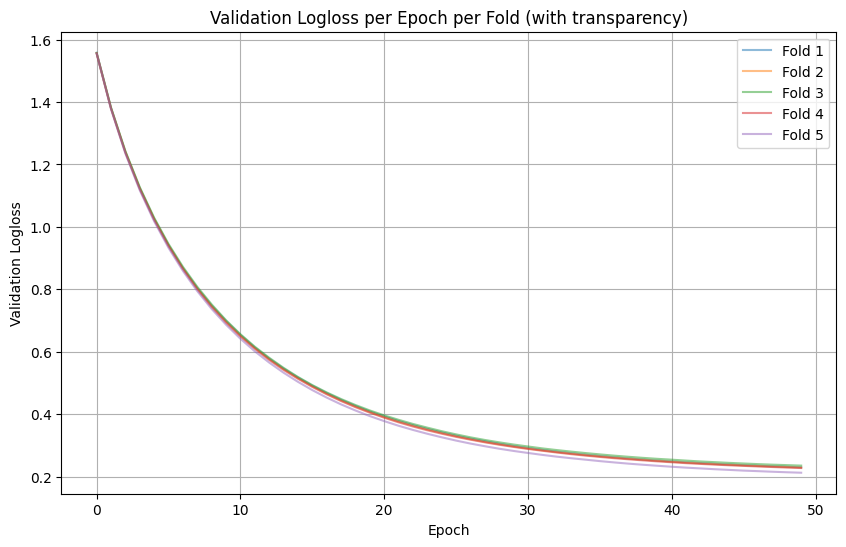

In [ ]:
# Melakukan visualisasi grafik validation logLoss per epoch per Fold dengan visualisasi transparan pada setiap kurvanya agar semua kurva terlihat
functions.plot_curve_transparent(fold_logloss_curve, metric_name="Validation Logloss")

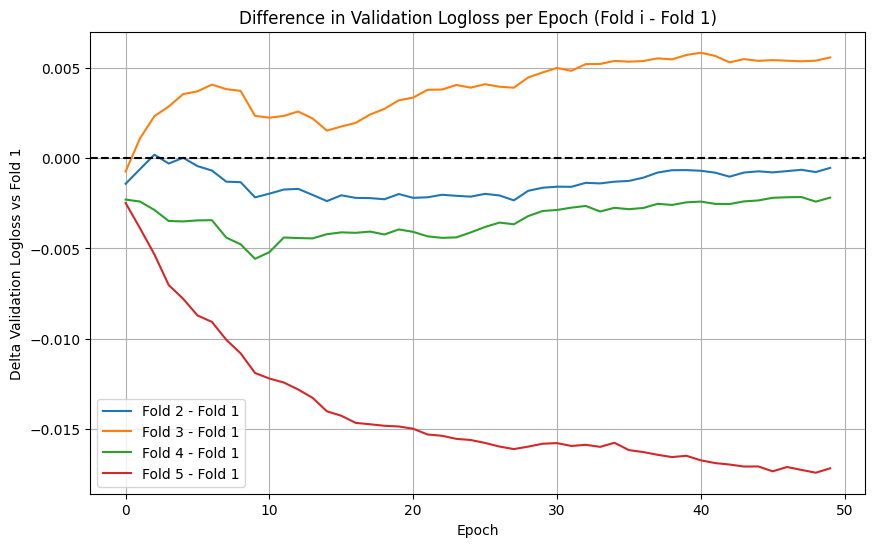

In [ ]:
# Menampilkan visualisasi perbedaan logloss per epoch
functions.plot_curve_deltas(fold_logloss_curve, metric_name="Validation Logloss")

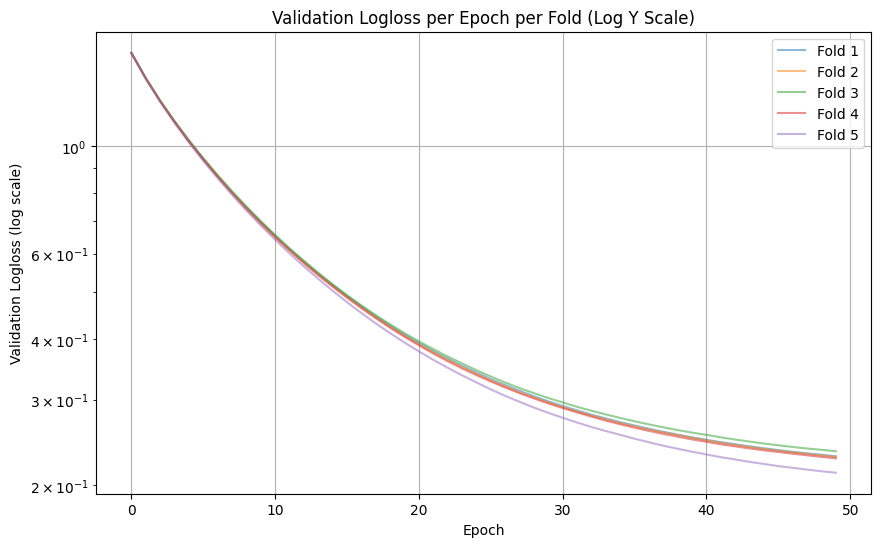

In [ ]:
# Menampilkan visualisasi log gamma-scale agar visualisasi antar kurva lebih terlihat
functions.plot_curve_logscale(fold_logloss_curve, metric_name="Validation Logloss")

## Grafik Accuracy

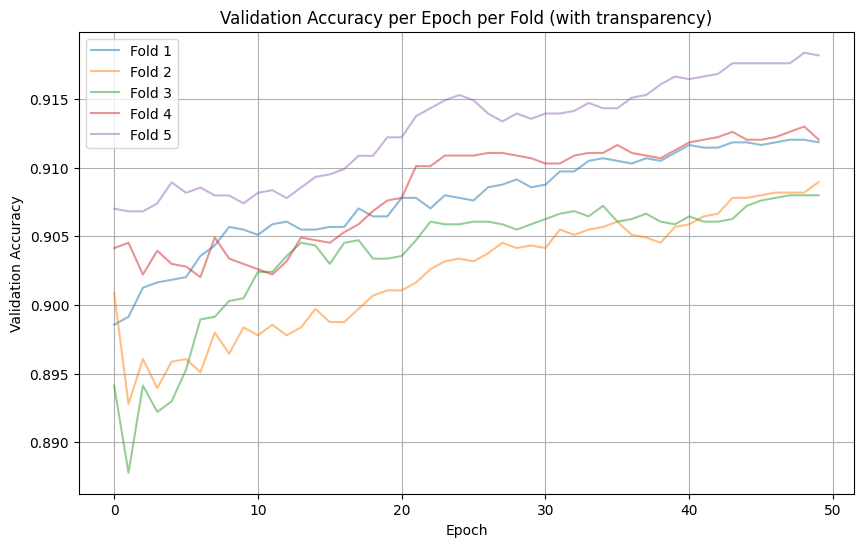

In [ ]:
# Melakukan visualisasi grafik validation accuracy per epoch per Fold dengan visualisasi transparan pada setiap kurvanya agar semua kurva terlihat
functions.plot_curve_transparent(fold_accuracy_curve, metric_name="Validation Accuracy")

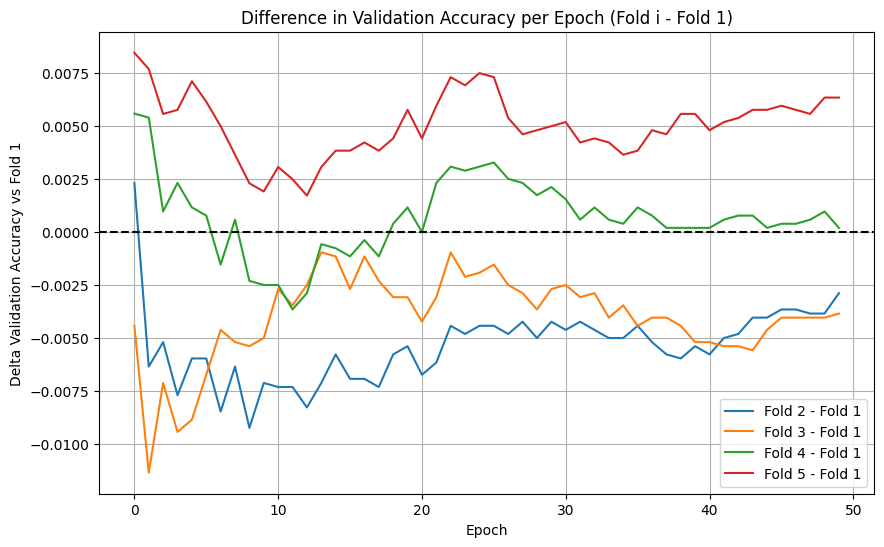

In [ ]:
# Menampilkan visualisasi perbedaan logloss per epoch
functions.plot_curve_deltas(fold_accuracy_curve, metric_name="Validation Accuracy")

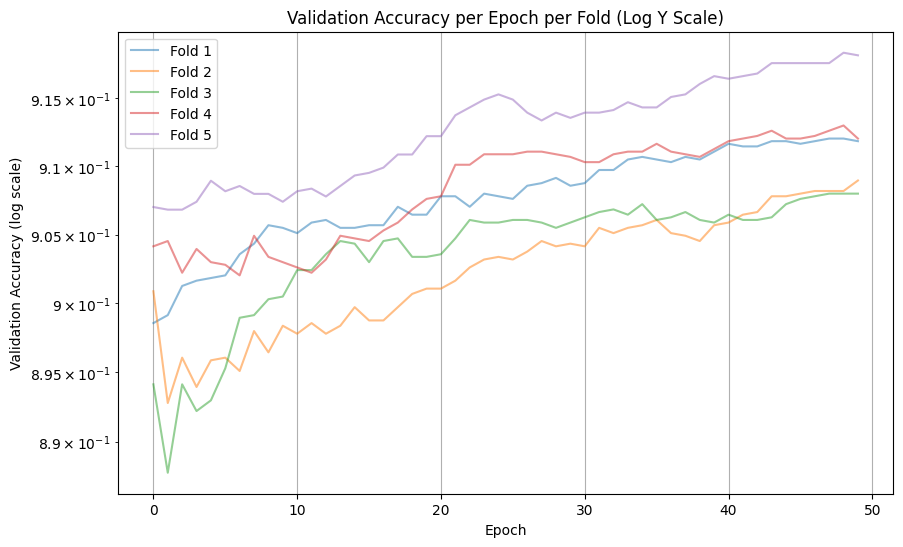

In [ ]:
# Menampilkan visualisasi log gamma-scale agar visualisasi antar kurva lebih terlihat
functions.plot_curve_logscale(fold_accuracy_curve, metric_name="Validation Accuracy")

## Rangkuman Hasil

In [ ]:
# Rangkuman hasil metrik setiap fold
results_df = pd.DataFrame(fold_results)
print("\n===== K-Fold Summary =====")
print(results_df)


===== K-Fold Summary =====
   fold  accuracy  f1_score  precision   roc_auc  log_loss
0     1  0.911838  0.907108   0.901063  0.991681  0.229501
1     2  0.908951  0.905636   0.900858  0.990706  0.228969
2     3  0.907988  0.904074   0.899165  0.990533  0.235098
3     4  0.912031  0.906941   0.901646  0.990929  0.227319
4     5  0.918175  0.913563   0.908770  0.992492  0.212299


In [ ]:
# Menampilkan rata-rata semua metrik dari semua fold
print("\nMean Metrics:")
print(results_df.drop(columns='fold').mean())


Mean Metrics:
accuracy     0.911797
f1_score     0.907464
precision    0.902300
roc_auc      0.991268
log_loss     0.226637
dtype: float64


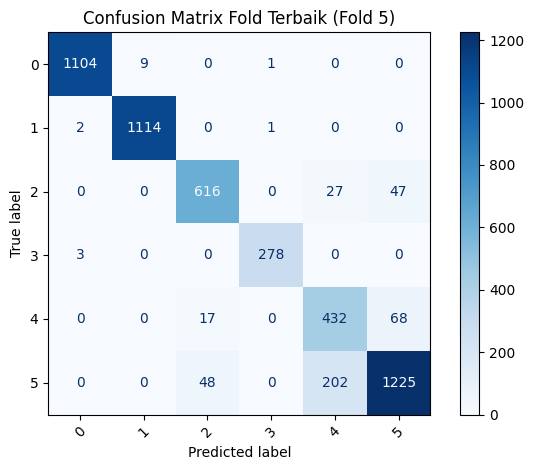

In [ ]:
# Menampilkan visualisasi keakuratan prediksi model
functions.plot_best_confusion_matrix(best_y_true, best_preds, best_fold)